Splunk MLToolkit example of "Predict Server Power Consumption" using pyspark keras and tensorflow

In [1]:
#pixdust speaks spark
import pandas as pd
#import pandas_datareader.data as web
from datetime import datetime
import numpy as np
import pixiedust
randn = np.random.randn
from matplotlib import pyplot as plt

Pixiedust database opened successfully


In [2]:
#get the url for the spark ui
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
import glob
filenames = glob.glob("data/server_power.csv")
server_power = pd.concat( [ pd.read_csv(f) for f in filenames ] )
server_power.describe()

,ac_power,total-unhalted_core_cycles,total-instructions_retired,total-last_level_cache_references,total-memory_bus_transactions,total-cpu-utilization,total-disk-accesses,total-disk-blocks,total-disk-utilization
count,31272.000000,3.127200e+04,3.127200e+04,3.127200e+04,3.127200e+04,31271.000000,31272.000000,31272.000000,31272.000000
mean,239.802467,2.309277e+09,2.714148e+09,1.443819e+08,5.145059e+06,97.564742,6.844126,193.496255,5.247245
std,24.206970,3.261582e+09,3.810763e+09,2.164751e+08,9.314938e+06,135.762684,24.023074,1130.485155,20.846893
min,218.000000,4.168413e+06,3.708610e+06,6.719500e+04,2.789000e+03,0.000000,0.000000,0.000000,0.000000
25%,225.000000,5.144853e+08,5.600434e+08,2.277050e+07,9.552775e+04,27.190000,0.000000,0.000000,0.000000
50%,230.000000,1.076023e+09,1.374843e+09,6.006047e+07,1.073730e+06,52.640000,0.000000,0.000000,0.000000
75%,242.000000,2.335011e+09,2.606795e+09,1.359125e+08,5.454786e+06,99.840000,8.410000,72.000000,5.250000
max,336.000000,1.861924e+10,3.799910e+10,1.172397e+09,5.672846e+07,800.000000,822.920000,18602.530000,252.160000


In [4]:
display(server_power)

_time,ac_power,total-unhalted_core_cycles,total-instructions_retired,total-last_level_cache_references,total-memory_bus_transactions,total-cpu-utilization,total-disk-accesses,total-disk-blocks,total-disk-utilization
00:46:00 2008-Apr-23,231.0,1302596297.0,2383365675.0,67514494.0,161593.0,52.18,0.0,0.0,0.0
00:22:08 2008-Apr-23,233.0,1325328562.0,1274060433.0,94152075.0,3165135.0,57.34,8.82,125.49,9.02
22:00:18 2008-Apr-22,226.0,774750839.0,1420805232.0,40398697.0,45174.0,29.83,0.0,0.0,0.0
20:23:51 2008-Apr-22,225.0,541153185.0,541185125.0,39844772.0,1068736.0,20.09,11.88,134.65,8.32
02:11:19 2008-Apr-23,260.0,4891468060.0,8120941193.0,271919746.0,3276794.0,200.7,0.0,0.0,0.0
00:42:23 2008-Apr-23,223.0,1112593345.0,2077130114.0,57290087.0,109236.0,55.13,0.0,0.0,0.0
00:45:19 2008-Apr-23,230.0,1311389902.0,2395387430.0,67670625.0,165851.0,51.74,0.0,0.0,0.0
21:42:08 2008-Apr-22,228.0,825502875.0,816657886.0,60269029.0,1609104.0,32.37,0.98,7.84,0.39
21:26:01 2008-Apr-22,224.0,353677498.0,721060649.0,22525628.0,40107.0,26.44,15.0,152.0,9.2
13:29:15 2008-Apr-15,225.0,21612672.0,9271176.0,418286.0,83947.0,1.0,79.17,3041.67,104.17


In [5]:
#data preperation
from pyspark.ml.regression import LinearRegression  
from pyspark.ml.feature import VectorAssembler  
from pyspark.ml.feature import StandardScaler  
data_sdf = spark.createDataFrame(server_power)

data_sdf = data_sdf \
    .withColumn('label',data_sdf.ac_power) 
    
features = ["total-unhalted_core_cycles", "total-instructions_retired", "total-last_level_cache_references", "total-memory_bus_transactions", "total-cpu-utilization", "total-disk-accesses", "total-disk-blocks", "total-disk-utilization"]
label = ["label"]  

model_data_sdf = data_sdf.select("label","ac_power","_time",*features)  
(training_data, test_data) = model_data_sdf.randomSplit([.7, .3])

In [6]:
#model_data_sdf.show()
model_data_sdf.printSchema()

root
 |-- label: double (nullable = true)
 |-- ac_power: double (nullable = true)
 |-- _time: string (nullable = true)
 |-- total-unhalted_core_cycles: double (nullable = true)
 |-- total-instructions_retired: double (nullable = true)
 |-- total-last_level_cache_references: double (nullable = true)
 |-- total-memory_bus_transactions: double (nullable = true)
 |-- total-cpu-utilization: double (nullable = true)
 |-- total-disk-accesses: double (nullable = true)
 |-- total-disk-blocks: double (nullable = true)
 |-- total-disk-utilization: double (nullable = true)



In [7]:
#machine learning used for just data preparation
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

#indexer = StringIndexer(inputCol="_time", outputCol="_time_Index")
##assembler = VectorAssembler(inputCols=[*features], outputCol="features")
##assembler = VectorAssembler(inputCols=["total-cpu-utilization","total-disk-utilization"], outputCol="features")
assembler = VectorAssembler(inputCols=["total-cpu-utilization"], outputCol="features")

#pipeline = Pipeline(stages=[indexer, assembler, lr])
pipeline = Pipeline(stages=[assembler])

model_prep = pipeline.fit(training_data)
predictionl_prep = model_prep.transform(training_data)


In [8]:
#predictionl_prep.show()
#display(prediction)
predictionl_prep.printSchema()


root
 |-- label: double (nullable = true)
 |-- ac_power: double (nullable = true)
 |-- _time: string (nullable = true)
 |-- total-unhalted_core_cycles: double (nullable = true)
 |-- total-instructions_retired: double (nullable = true)
 |-- total-last_level_cache_references: double (nullable = true)
 |-- total-memory_bus_transactions: double (nullable = true)
 |-- total-cpu-utilization: double (nullable = true)
 |-- total-disk-accesses: double (nullable = true)
 |-- total-disk-blocks: double (nullable = true)
 |-- total-disk-utilization: double (nullable = true)
 |-- features: vector (nullable = true)



In [38]:
dataframeX = predictionl_prep.select('total-cpu-utilization','total-disk-utilization').toPandas()
dataframeY = predictionl_prep.select('ac_power').toPandas()
dataframeX.head(5)
dataframeY.head(5)

,ac_power
0,219.0
1,219.0
2,219.0
3,219.0
4,219.0


In [33]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(2, input_dim=2, activation="relu", kernel_initializer="uniform"))
model.add(Dense(2, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 6         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 3         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%bash
pwd
#tensorboard --logdir=logs/

/Users/nicholasmanolakos/DataScience


Train on 15310 samples, validate on 6562 samples
Epoch 1/2
15310/15310 [==============================] - 2s 113us/step - loss: nan - coeff_determination: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - acc: 0.0000e+00 - val_loss: nan - val_coeff_determination: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_acc: 0.0000e+00
Epoch 2/2
15310/15310 [==============================] - 2s 99us/step - loss: nan - coeff_determination: nan - mean_squared_error: nan - mean_absolute_error: nan - mean_absolute_percentage_error: nan - acc: 0.0000e+00 - val_loss: nan - val_coeff_determination: nan - val_mean_squared_error: nan - val_mean_absolute_error: nan - val_mean_absolute_percentage_error: nan - val_acc: 0.0000e+00


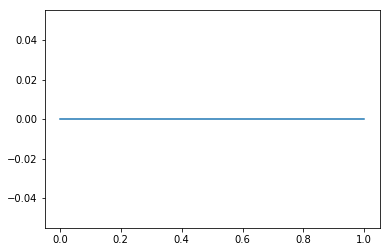

In [35]:
#deep machine learning 
from keras import backend as K

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss='mean_squared_error',optimizer='adam', metrics=[coeff_determination, 'mse', 'mae', 'mape', 'acc'])
history = model.fit(dataframeX.values, dataframeY.values, batch_size=32, epochs=2, verbose=1,validation_split=0.3 )
# plot metrics
plt.plot(history.history['acc'])
plt.show()         

In [13]:
#save/load model for another time


In [14]:
#ts.residuals.show()

In [15]:
#pdf = ts.residuals.toPandas()
#pdf.insert(0, 'ID', range(0, len(pdf)))

In [16]:
#display(pdf)

In [17]:
#with spark sql
#prediction.createOrReplaceTempView("prediction")
#sqlDF = spark.sql("SELECT monotonically_increasing_id() as id, (ac_power - prediction_ac_power) as residuals  FROM prediction")
#sqlDF.show()
#display(sqlDF)

In [18]:
#with native manipulation
#ts.residuals.agg({"residuals": "avg"}).show()